Colab で動かす場合、ランタイムを GPU にしてください。

# はじめに

モデルフリー方策は、環境のモデルを用いずに行動選択を行う方法です。

<div style="text-align: center">
<img width="300" alt="model-free.png (54.9 kB)" src="https://img.esa.io/uploads/production/attachments/21189/2024/01/17/160121/c17e299d-bd9c-46e1-b53d-6ad924771c11.png">
</div>

ここでの実装は、[CleanRL](https://github.com/vwxyzjn/cleanrl/tree/master) の [ddpg_continuous_action.py](https://github.com/vwxyzjn/cleanrl/blob/master/cleanrl/ddpg_continuous_action_jax.py) をベースにしています。

# 実装

### ライブラリの準備

In [1]:
# ライブラリのインストール
!pip install brax -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.3/172.3 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 9.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 48.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 66.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 55.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 690.0/690.0 kB 40.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.8/211.8 kB 22.2 MB/s eta 0:00:00


In [2]:
# ライブラリのインポート
import matplotlib.pyplot as plt
import numpy as np
import jax
import jax.numpy as jnp
import flax
import flax.linen as nn
import optax

from IPython.display import HTML, clear_output
from tqdm.notebook import tqdm
from flax.linen.initializers import constant, orthogonal
from flax.training.train_state import TrainState
from brax import envs
from brax.io import html

# 乱数のシードを設定
key = jax.random.PRNGKey(42)

### 環境の定義

In [3]:
env = envs.get_environment(env_name='halfcheetah', backend='positional')
episode_length = 200

# jit コンパイル設定
env_reset = jax.jit(env.reset)
env_step = jax.jit(env.step)

# 状態と行動の次元を取得
obs_dim = env.observation_size
action_dim = env.action_size

print(f"obs_dim: {obs_dim}, action_dim: {action_dim}")

obs_dim: 17, action_dim: 6


In [4]:
# モデル学習用のハイパーパラメータ
learning_rate = 0.001
total_timesteps = 50000
learning_starts = 5000
batch_size = 512
gamma = 0.99
tau = 0.01
grad_clip_norm = 20.0
exploration_noise = 0.1

### モデルの定義

In [5]:
class Actor(nn.Module):
    action_dim: int

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(64, kernel_init=orthogonal(1), bias_init=constant(0))(x)
        x = nn.elu(x)
        x = nn.Dense(64, kernel_init=orthogonal(1), bias_init=constant(0))(x)
        x = nn.elu(x)
        x = nn.Dense(self.action_dim, kernel_init=orthogonal(1), bias_init=constant(0))(x)
        x = nn.tanh(x)
        return x


class QNetwork(nn.Module):
    @nn.compact
    def __call__(self, x, a):
        x = jnp.concatenate([x, a], -1)
        x = nn.Dense(64, kernel_init=orthogonal(1), bias_init=constant(0))(x)
        x = nn.elu(x)
        x = nn.Dense(64, kernel_init=orthogonal(1), bias_init=constant(0))(x)
        x = nn.elu(x)
        x = nn.Dense(1, kernel_init=orthogonal(1e-5), bias_init=constant(0))(x)
        return x


# モデルの定義
actor = Actor(action_dim)
qf = QNetwork()

# コンパイル設定
actor.apply = jax.jit(actor.apply)
qf.apply = jax.jit(qf.apply)

class TrainState(TrainState):
    target_params: flax.core.FrozenDict

key, actor_key, qf1_key, qf2_key = jax.random.split(key, 4)

actor_state = TrainState.create(
    apply_fn = actor.apply,
    params = actor.init(actor_key, jnp.ones(obs_dim)),
    target_params = None,
    tx = optax.adam(learning_rate=learning_rate)
)

qf1_state = TrainState.create(
    apply_fn = qf.apply,
    params = qf.init(qf1_key, jnp.zeros(obs_dim), jnp.zeros(action_dim)),
    target_params = qf.init(qf1_key, jnp.zeros(obs_dim), jnp.zeros(action_dim)),
    tx = optax.adam(learning_rate=learning_rate)
)

qf2_state = TrainState.create(
    apply_fn = qf.apply,
    params = qf.init(qf2_key, jnp.zeros(obs_dim), jnp.zeros(action_dim)),
    target_params = qf.init(qf2_key, jnp.zeros(obs_dim), jnp.zeros(action_dim)),
    tx = optax.adam(learning_rate=learning_rate)
)

### リプレイバッファ

In [6]:
class ReplayBuffer():
    def __init__(self, total_timesteps, episode_length, obs_dim, action_dim):

        # バッファの定義
        num_episode = (total_timesteps // episode_length) + 1
        self.obs_buffer = np.empty((num_episode, episode_length + 1, obs_dim), dtype=np.float32)
        self.action_buffer = np.empty((num_episode, episode_length, action_dim), dtype=np.float32)
        self.reward_buffer = np.empty((num_episode, episode_length), dtype=np.float32)

        self.episode_length = episode_length
        self.iter = 0

    def add(self, obss, actions, rewards):

        # バッファにシーケンスを格納
        self.obs_buffer[self.iter] = obss
        self.action_buffer[self.iter] = actions
        self.reward_buffer[self.iter] = rewards
        self.iter += 1

    def sample(self, batch_size):

        # バッファから取得する要素の index をサンプリング
        idx = np.random.randint(self.iter, size=batch_size)
        idy = np.random.randint(self.episode_length, size=batch_size)

        # バッファからデータを取得
        obs = self.obs_buffer[idx, idy]
        action = self.action_buffer[idx, idy]
        reward = self.reward_buffer[idx, idy]
        next_obs = self.obs_buffer[idx, idy+1]

        return obs, action, reward, next_obs


rb = ReplayBuffer(total_timesteps, episode_length, obs_dim, action_dim)

## 学習用関数

In [7]:
@jax.jit
def update_critic(
    actor_state,
    qf1_state,
    qf2_state,
    obs,
    action,
    next_obs,
    reward,
):

    # ターゲットの計算
    next_state_action = actor.apply(actor_state.params, next_obs)
    qf1_next_target = qf.apply(qf1_state.target_params, next_obs, next_state_action).reshape(-1)
    qf2_next_target = qf.apply(qf2_state.target_params, next_obs, next_state_action).reshape(-1)
    min_qf_next_target = jnp.minimum(qf1_next_target, qf2_next_target)
    qf_target = (reward + gamma * (min_qf_next_target)).reshape(-1)

    # 損失関数
    def mse_loss(params):
        qf_a_value = qf.apply(params, obs, action).squeeze()
        return ((qf_a_value - qf_target) ** 2).mean()

    # 勾配を計算
    grads1 = jax.grad(mse_loss)(qf1_state.params)
    grads2 = jax.grad(mse_loss)(qf2_state.params)

    # パラメータを更新
    qf1_state = qf1_state.apply_gradients(grads=grads1)
    qf2_state = qf2_state.apply_gradients(grads=grads2)

    # パラメータの移動平均を計算
    qf1_state = qf1_state.replace(target_params=optax.incremental_update(qf1_state.params, qf1_state.target_params, tau))
    qf2_state = qf2_state.replace(target_params=optax.incremental_update(qf2_state.params, qf2_state.target_params, tau))

    return qf1_state, qf2_state


@jax.jit
def update_actor(
    actor_state,
    qf1_state,
    qf2_state,
    obs,
):

    # 損失関数
    def actor_loss(params):
        actions = actor.apply(params, obs)
        qf1_value = qf.apply(qf1_state.params, obs, actions)
        qf2_value = qf.apply(qf2_state.params, obs, actions)
        min_qf_value = jnp.minimum(qf1_value, qf2_value)
        return - jnp.mean(min_qf_value)

    # 勾配計算
    grads = jax.grad(actor_loss)(actor_state.params)

    # パラメータを更新
    actor_state = actor_state.apply_gradients(grads=grads)

    return actor_state

### データ収集用関数

In [8]:
@jax.jit
def random_rollout(key):
    def body_fn(env_state, key):
        action = jax.random.uniform(key, (action_dim,), minval=-1.0, maxval=1.0)
        env_state = env_step(env_state, action)
        return env_state, (env_state.obs, action, env_state.reward)

    keys = jax.random.split(key, episode_length)
    env_state = env_reset(key)
    init_x = env_state.obs
    _, (xs, us, rs) = jax.lax.scan(body_fn, env_state, keys)
    xs = jnp.concatenate([init_x.reshape(1, -1), xs])
    return xs, us, rs

@jax.jit
def policy_rollout(key, actor_state):
    def body_fn(env_state, key):
        action = actor.apply(actor_state.params, env_state.obs)
        action = action + exploration_noise * jax.random.normal(key, (action_dim,))
        action = action.clip(-1.0, 1.0)
        env_state = env_step(env_state, action)
        return env_state, (env_state.obs, action, env_state.reward)

    keys = jax.random.split(key, episode_length)
    env_state = env_reset(key)
    init_x = env_state.obs
    _, (xs, us, rs) = jax.lax.scan(body_fn, env_state, keys)
    xs = jnp.concatenate([init_x.reshape(1, -1), xs])
    return xs, us, rs

### 学習の実行

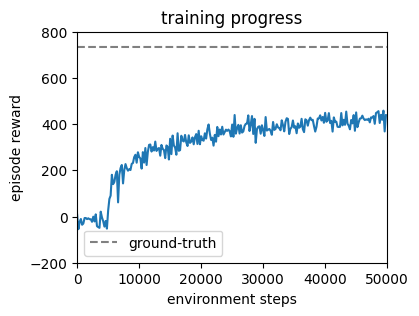

  0%|          | 0/200 [00:00<?, ?it/s]

In [9]:
xdata, ydata = [], []
def progress(global_step, episodic_return):
    xdata.append(global_step)
    ydata.append(episodic_return)
    clear_output(wait=True)
    plt.figure(figsize=(4,3))
    plt.plot(xdata, ydata)

    # モデルベース方策の結果
    sim_reward_sum = 733.9458618164062
    xs = np.arange(total_timesteps)
    ys = np.ones((total_timesteps,)) * sim_reward_sum
    plt.plot(xs, ys, color="gray", linestyle="--", label="ground-truth")
    plt.legend()

    plt.xlim([0, total_timesteps])
    plt.ylim([-200, 800])
    plt.xlabel('environment steps')
    plt.ylabel('episode reward')
    plt.title('training progress')
    plt.show()


for global_step in range(0, total_timesteps, episode_length):

    if global_step <= learning_starts:
        key, subkey = jax.random.split(key)
        obss, actions, rewards = random_rollout(subkey)

    else:
        key, subkey = jax.random.split(key)
        obss, actions, rewards = policy_rollout(subkey, actor_state)

    rb.add(obss, actions, rewards)
    episodic_return = np.sum(rewards)
    progress(global_step, episodic_return)

    train_metrics = {}
    if global_step >= learning_starts:
        num_updates = learning_starts if global_step == learning_starts else episode_length
        for i in tqdm(range(num_updates)):

            obs, actions, rewards, next_obs = rb.sample(batch_size)

            qf1_state, qf2_state = update_critic(
                actor_state,
                qf1_state,
                qf2_state,
                obs,
                actions,
                next_obs,
                rewards
            )

            actor_state = update_actor(
                actor_state,
                qf1_state,
                qf2_state,
                obs,
            )

### 学習結果の可視化

In [10]:
key, subkey = jax.random.split(key)
env_state = env_reset(subkey)
rollout = [env_state.pipeline_state]

reward_sum = 0.0
for _ in tqdm(range(episode_length)):
    action = actor.apply(actor_state.params, env_state.obs)
    env_state = env_step(env_state, action)
    reward_sum += env_state.reward

    rollout.append(env_state.pipeline_state)

print(f"reward_sum: {reward_sum}")
HTML(html.render(env.sys.replace(dt=env.dt), rollout))

  0%|          | 0/200 [00:00<?, ?it/s]

reward_sum: 417.6897888183594
